# Rag From Scratch: Query Transformations
Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval.

## Enviornment
(1) Packages

In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

(2) LangSmith

https://docs.smith.langchain.com/

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = ""

(3) API Keys

In [4]:
os.environ['OPENAI_API_KEY'] = ""

## Index

In [5]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

## Prompt

In [6]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [8]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

C:\Users\sonya\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


6

In [11]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This enables the agent to efficiently handle complex tasks by dividing them into more manageable steps.'

## Part 6: RAG-Fusion

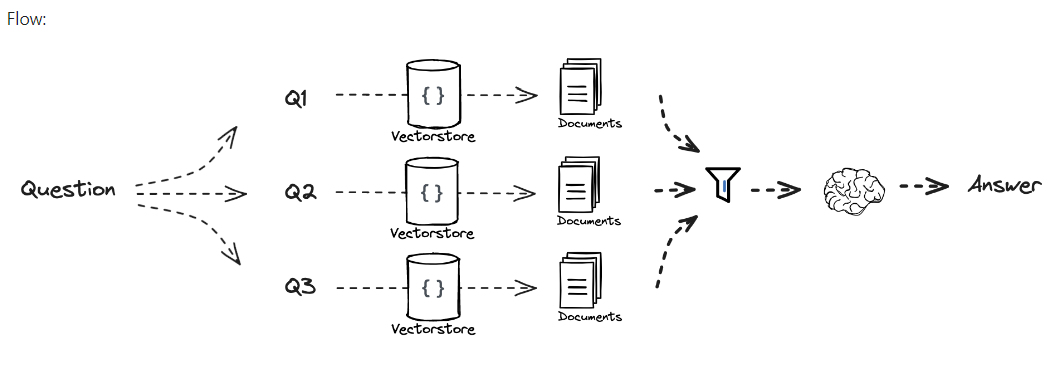

Prompt

In [12]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [14]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

7

In [15]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down complex tasks into smaller and simpler steps to enhance model performance. This can be achieved through techniques like Chain of Thought (CoT) and Tree of Thoughts, which prompt the model to think step by step and explore multiple reasoning possibilities at each step. Task decomposition can be done using simple prompting, task-specific instructions, or with human inputs to help the LLM agent effectively plan and execute tasks.'

## Part 7: Decomposition

In [16]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [17]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

In [18]:
questions

['1. What is LLM technology and how does it work in autonomous agent systems?',
 '2. What are the specific components that make up an autonomous agent system powered by LLM?',
 '3. How do the main components of an LLM-powered autonomous agent system interact with each other to achieve autonomy?']

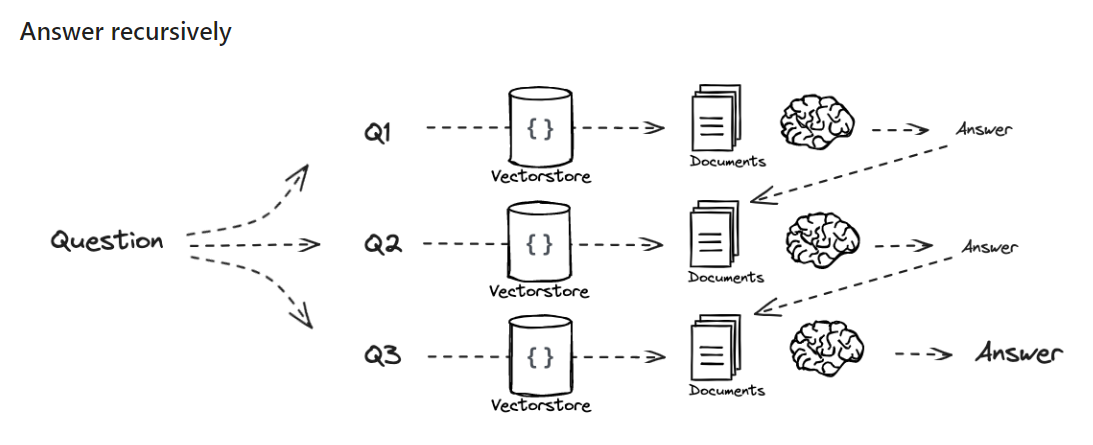

In [20]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [21]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [22]:
answer

"In an LLM-powered autonomous agent system, the main components interact with each other in a coordinated manner to achieve autonomy. \n\n1. Planning: The agent utilizes task decomposition to break down complex tasks into smaller subgoals, making them more manageable. This allows the agent to plan ahead and navigate through the steps required to accomplish the overall task efficiently.\n\n2. Memory: The agent's memory stores information and past experiences, which aids in decision-making and learning. By referencing past actions and outcomes, the agent can improve its future actions and decision-making processes.\n\n3. External Classical Planner (LLM+P approach): This component involves outsourcing long-horizon planning to an external classical planner. The agent translates the problem into PDDL, generates a plan, and then translates it back into natural language. This collaboration between the agent and the external planner enhances the agent's ability to handle complex tasks effectiv

In [23]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

C:\Users\sonya\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [24]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system include planning, task decomposition, reflection, and refinement. Planning is used to break down complex tasks into manageable subgoals, while task decomposition can be achieved through various methods such as simple prompting by LLM or human inputs. Reflection allows the agent to analyze past actions and make improvements, leading to enhanced performance in real-world tasks. These components work together to enable autonomous behavior and efficient decision-making in autonomous agent systems.'

## Part 8: Step Back

The main aim is to take in input question and translate it into such a way that it improves the retrieval.

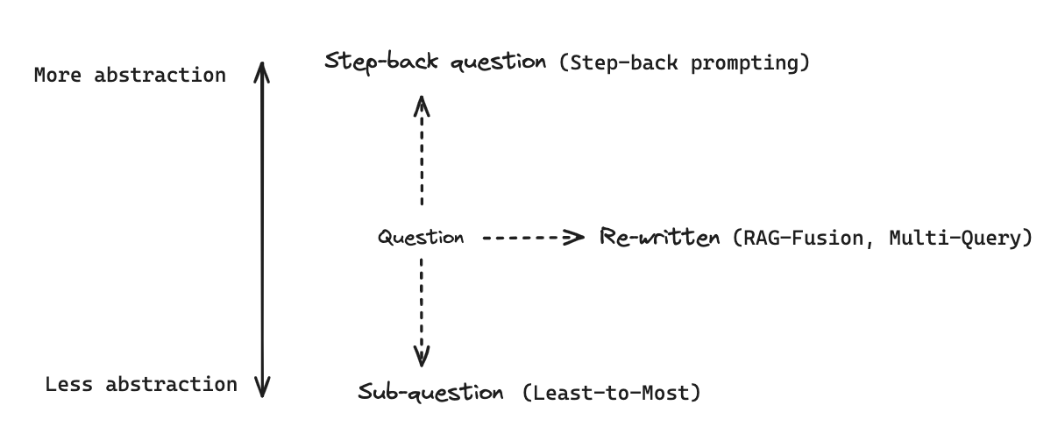

In [25]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [26]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

'What is the process of breaking down tasks for LLM agents?'

In [27]:
# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM agents refers to the process of breaking down large and complex tasks into smaller, more manageable subgoals. This allows the LLM-powered autonomous agent to efficiently handle intricate tasks by dividing them into simpler steps. Task decomposition is a crucial component of the planning phase in an LLM-powered autonomous agent system, where the agent needs to know the steps involved in a task and plan ahead accordingly.\n\nThere are various techniques and approaches to task decomposition for LLM agents. One common method is the Chain of Thought (CoT) technique, which prompts the model to "think step by step" and decompose hard tasks into smaller and simpler steps. CoT transforms large tasks into multiple manageable tasks, providing insights into the model\'s thinking process. Another extension of CoT is the Tree of Thoughts, which explores multiple reasoning possibilities at each step by generating multiple thoughts per step and creating a tree structure. Th

## Part 9: HyDE

The idea is to convert the question and document into embedded format and search the similarity. HyDE technique will map the question into a hypothetical document. 

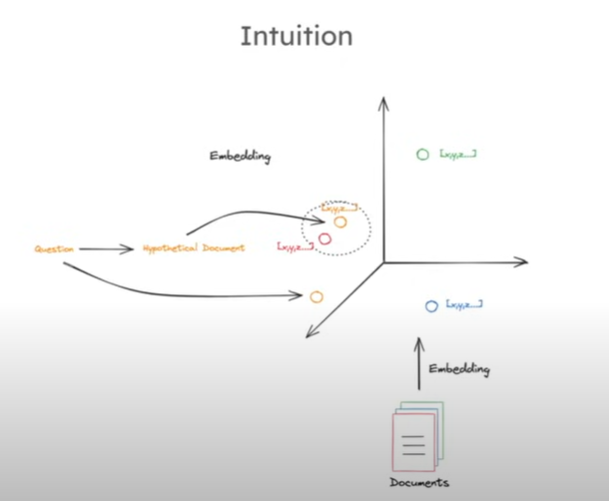

In [28]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

'Task decomposition is a fundamental concept in the field of reinforcement learning and artificial intelligence, particularly for Large Language Models (LLMs) agents. Task decomposition refers to the process of breaking down a complex task into smaller, more manageable sub-tasks that can be solved independently or sequentially. This approach allows LLM agents to effectively tackle complex problems by dividing them into smaller, more easily solvable components.\n\nIn the context of LLM agents, task decomposition involves breaking down a high-level task, such as generating a coherent paragraph of text or answering a complex question, into smaller sub-tasks that can be addressed individually. For example, when generating a paragraph of text, the LLM agent may first identify the main topic, then generate an outline, and finally fill in the details to create a coherent and cohesive paragraph.\n\nTask decomposition for LLM agents is crucial for improving the efficiency and effectiveness of t

In [29]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via 

In [30]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This enables the agent to efficiently handle complex tasks by dividing them into multiple manageable tasks, making it easier for the agent to navigate and solve the overall problem.'